In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use("ggplot")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

Load Fashion-MNIST again (as tensors)

In [4]:
data_dir = "../data"

transform = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root=data_dir,
    train=False,
    download=True,
    transform=transform
)

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

len(train_dataset), len(test_dataset)


(60000, 10000)

For training the autoencoder, we’ll use a subset at first (to keep it fast)

In [5]:
n_train_samples = 20000  # you can increase later
train_subset = Subset(train_dataset, range(n_train_samples))

batch_size = 128
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)


For evaluation, we’ll reuse the same 1000 images logic, but now via DataLoader

In [6]:
n_eval = 1000
eval_subset = Subset(test_dataset, range(n_eval))
eval_loader = DataLoader(eval_subset, batch_size=batch_size, shuffle=False)


Define the Autoencoder model
fully-connected (MLP) undercomplete autoencoder with latent dimension LATENT_DIM.
 LATENT_DIM = 64 so later compare PCA with k=64.

In [7]:
LATENT_DIM = 64

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        # 28x28 = 784
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),   # because pixels are in [0,1]
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        x_hat = x_hat.view(-1, 1, 28, 28)
        return x_hat

model = Autoencoder(latent_dim=LATENT_DIM).to(device)
model


Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

Training setup
Loss + optimizer

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Training loop

In [9]:
def train_autoencoder(model, dataloader, criterion, optimizer, device, epochs=20):
    model.train()
    history = []
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for imgs, _ in dataloader:
            imgs = imgs.to(device)  # imgs: (batch_size, 1, 28, 28)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, imgs)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * imgs.size(0)
        
        epoch_loss /= len(dataloader.dataset)
        history.append(epoch_loss)
        print(f"Epoch {epoch+1:02d}/{epochs} - loss: {epoch_loss:.6f}")
    
    return history

epochs = 20
history = train_autoencoder(model, train_loader, criterion, optimizer, device, epochs=epochs)


Epoch 01/20 - loss: 0.051630
Epoch 02/20 - loss: 0.023671
Epoch 03/20 - loss: 0.019912
Epoch 04/20 - loss: 0.017805
Epoch 05/20 - loss: 0.016369
Epoch 06/20 - loss: 0.015421
Epoch 07/20 - loss: 0.014360
Epoch 08/20 - loss: 0.013656
Epoch 09/20 - loss: 0.013069
Epoch 10/20 - loss: 0.012596
Epoch 11/20 - loss: 0.012055
Epoch 12/20 - loss: 0.011668
Epoch 13/20 - loss: 0.011386
Epoch 14/20 - loss: 0.010989
Epoch 15/20 - loss: 0.010706
Epoch 16/20 - loss: 0.010436
Epoch 17/20 - loss: 0.010219
Epoch 18/20 - loss: 0.009979
Epoch 19/20 - loss: 0.009798
Epoch 20/20 - loss: 0.009611


Save AE model

In [10]:
os.makedirs("../models", exist_ok=True)
torch.save(model.state_dict(), "../models/autoencoder_fmnist_latent64.pth")


Plot training loss

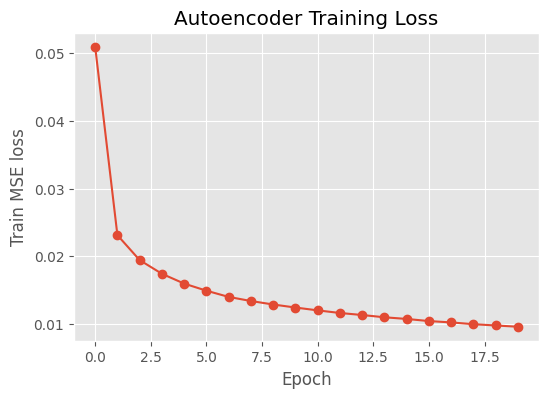

In [10]:
plt.figure(figsize=(6,4))
plt.plot(history, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Train MSE loss")
plt.title("Autoencoder Training Loss")
plt.show()


Evaluate reconstruction quality (MSE) vs PCA
compute MSE on the same number of eval images (n_eval = 1000)

Get original and reconstructed images from (AE Autoencoder)

In [11]:
model.eval()

all_original = []
all_reconstructed = []

with torch.no_grad():
    for imgs, _ in eval_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        
        all_original.append(imgs.cpu().numpy())
        all_reconstructed.append(outputs.cpu().numpy())

X_orig_ae = np.concatenate(all_original, axis=0)      # (n_eval, 1, 28, 28)
X_rec_ae = np.concatenate(all_reconstructed, axis=0)  # (n_eval, 1, 28, 28)

X_orig_ae_flat = X_orig_ae.reshape(n_eval, -1) / 1.0  # (n_eval, 784)
X_rec_ae_flat = X_rec_ae.reshape(n_eval, -1)

ae_mse = mean_squared_error(X_orig_ae_flat, X_rec_ae_flat)
ae_mse


0.00970790721476078

Original vs AE

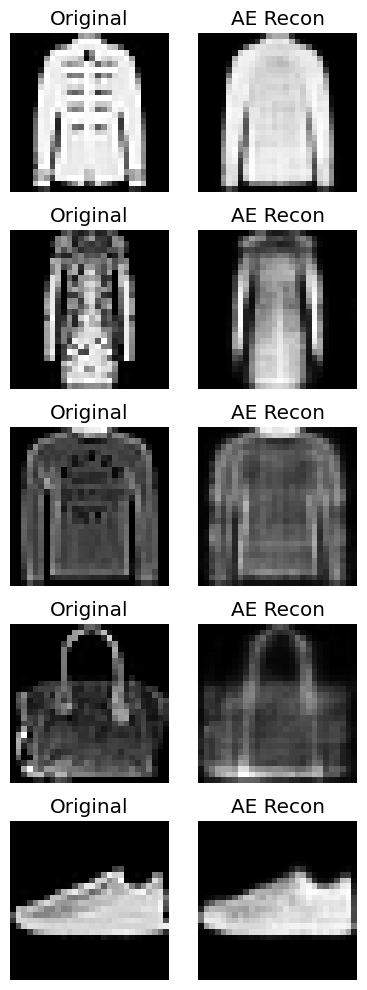

In [12]:
def show_ae_reconstructions(X_orig, X_rec, n_images=5):
    idxs = np.random.choice(X_orig.shape[0], size=n_images, replace=False)
    
    fig, axes = plt.subplots(n_images, 2, figsize=(4, 2 * n_images))
    
    for row, idx in enumerate(idxs):
        axes[row, 0].imshow(X_orig[idx].reshape(28, 28), cmap="gray")
        axes[row, 0].set_title("Original")
        axes[row, 0].axis("off")
        
        axes[row, 1].imshow(X_rec[idx].reshape(28, 28), cmap="gray")
        axes[row, 1].set_title("AE Recon")
        axes[row, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

show_ae_reconstructions(X_orig_ae_flat, X_rec_ae_flat, n_images=5)


## Autoencoder Summary

- I trained a fully-connected undercomplete autoencoder with a latent dimension of 64 on Fashion-MNIST.
- The model learns a nonlinear mapping:
  - Encoder: 784 → 256 → 64
  - Decoder: 64 → 256 → 784
- The training loss (MSE) decreased steadily over epochs, indicating that the autoencoder is learning to reconstruct the input images.

On a held-out test subset (~1000 images):

- The autoencoder reconstruction MSE was: **<insert ae_mse value here>**.
- This can be directly compared to PCA with **k = 64** components to evaluate how much benefit we get from a nonlinear representation.

Next, I will:
- directly compare PCA vs Autoencoder reconstruction side-by-side
- visualize latent spaces
- and analyze when linear PCA is sufficient vs when a nonlinear autoencoder has an advantage.
